In [1]:
'''
輸入：
證券代號
期間(起訖日)

產出：
期間內K線圖
期間內趨勢線(移動平均線)
期間內成交量
'''

'\n輸入：\n證券代號\n期間(起訖日)\n\n產出：\n期間內K線圖\n期間內趨勢線(移動平均線)\n期間內成交量\n'

In [2]:
'''
採用資料：
蠟燭線-最高價、最低價
蠟燭身-開盤價、收盤價
如開盤價<收盤價(上漲)   ==> 陽線(紅色)
如開盤價>收盤價(下跌)   ==> 陰線(綠色)
'''

'\n採用資料：\n蠟燭線-最高價、最低價\n蠟燭身-開盤價、收盤價\n如開盤價<收盤價(上漲)   ==> 陽線(紅色)\n如開盤價>收盤價(下跌)   ==> 陰線(綠色)\n'

In [3]:
'''
二個df
1.data 最後長相：有Volume,K,D等等
2.data_df 為配合candlestick，只能有[DateTime,Open,High,Low,Close]

注意
畫圖的程式碼設定，資料一定要大於50天才會有辦法畫出來喔！

'''

'\n二個df\n1.data 最後長相：有Volume,K,D等等\n2.data_df 為配合candlestick，只能有[DateTime,Open,High,Low,Close]\n\n注意\n畫圖的程式碼設定，資料一定要大於50天才會有辦法畫出來喔！\n\n'

In [4]:
import requests
import io
import pandas as pd
import time
import mplfinance as mpf

In [5]:
def repl(listo,ind,A,B): #phase1
    a = len(A)
    if listo[1][ind:ind+a] == A:
            listo[1] = listo[1][:ind] + B + listo[1][ind+a:]

In [6]:
def crawler( StockCode, yy, mm): #phase2
    MM = lambda mm: '0' + str(mm) if mm < 10 else str(mm)
    page = requests.get('https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=csv&date='+ str(yy) + MM(mm) +'01&stockNo='+str(StockCode)).text.splitlines()
    
    for i, text in enumerate(page): #插入換行符
         page[i] = page[i][:-2] + '"\n'
  
    for i,text in enumerate(page): #找出資料終點
         if '/' == page[i][4:5]:
            end_point = i+1
    for i, text in enumerate(page): #找出資料起點
         if '/' == page[i][4:5]:
            start_point = i
            break 
            
    for i, text in enumerate(page):  #民國年換西元年      
        if page[i][4:5] == '/':
            page[i] =  page[i][:1] + str(int(page[i][1:4])+1911) + page[i][4:]
            
    for i in range(len(page[1])): #取代標題
        repl(page,i,'日期','Date')
        repl(page,i,'開盤價','Open')
        repl(page,i,'最高價','High')
        repl(page,i,'最低價','Low')
        repl(page,i,'收盤價','Close')
        repl(page,i,'成交股數','Volume')
        
    table = ''.join(list(page[start_point-1:end_point])) #把page(list)用join組合成一個字串
    table_df = pd.read_csv(io.StringIO(table), parse_dates=['Date'],index_col=0).dropna()
    #parse_date將table_df['日期']轉換成datetime形式，index_col=0是把第一欄當作索引值

    for i in range(len(table_df['Volume'])): #把逗點去掉
        for j in range(len(table_df['Volume'][i])):
            if table_df['Volume'][i][j:j+1] == ',':
                table_df['Volume'][i] = table_df['Volume'][i][:j]  + table_df['Volume'][i][j+1:]

        table_df['Volume'][i]=int(table_df['Volume'][i]) #不行用這行改變型態也，雖然成功轉換成"Int"object，可是
        #ax1v.fill_between在讀取的時候會報錯，為什麼QQ
    table_df['Volume'].astype(int) #這個還是"str"object阿(用data['Volume'][0].dtype測的)，為什麼ax1v.fill_between就給過QQ 
    return table_df

In [7]:
def BigCrawler( StockCode, yy, mm, dd, YY, MM, DD): #phase3，小寫前時間，大寫後時間

    Y_list = []
    YM_list = []
    
    yy = yy-1 #抓往前一年的資訊(也就是為了KD平滑，多抓了一年的資料)

    if type(yy) != int or type(YY) != int:
        print('請輸入數字！')

    elif YY > yy or YY == yy :
        for i in range((YY-yy)+1):
                years = yy+i
                Y_list.append(years)
        for i in range(len(Y_list)-1):
            while mm < 13 :
                temp = Y_list[i]*100 + mm
                mm += 1
                YM_list.append(str(temp))
            mm = 1
        while mm <= MM:
            temp = Y_list[-1]*100 + mm
            mm += 1
            YM_list.append(str(temp))

    elif YY < yy :
        print('過去年份大於近年年份！')

    print(Y_list)   
    print(YM_list)
    
    
    df = crawler(StockCode,int(YM_list[0][:4]),int(YM_list[0][-2:]))                 
    for i in range(1,len(YM_list)):
        time.sleep(5)
        df = pd.concat([df,crawler(StockCode,int(YM_list[i][:4]),int(YM_list[i][-2:]))])

    return df

In [8]:
StockCode=1216
data = BigCrawler(StockCode, 2020, 3, 1, 2020, 4, 21)
data_df = data[['Open','High','Low','Close']]
#data.to_csv('data.csv')

[2019, 2020]
['201903', '201904', '201905', '201906', '201907', '201908', '201909', '201910', '201911', '201912', '202001', '202002', '202003', '202004']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
print(data_df.shape)

(277, 4)


In [52]:
#起點
def findIndex(yy, mm, dd):
    month = lambda mm: '0' + str(mm) if mm < 10 else str(mm)
    day = lambda dd: '0' + str(dd) if dd < 10 else str(dd)
    dataIndex = []
    lenth = data.shape #輸出是一個tuple
    print(lenth)

    for i in range(0,lenth[0]):
        if data.index[i] == pd.Timestamp(str(yy)+'-'+month(mm)+'-'+day(dd)+' 00:00:00'):
            ans = i
            break
            
        else:
            ans = '這天股市沒有交易！'

    print(ans)


start = findIndex(2020, 3, 2) 
end = findIndex(2020, 4, 21)  

(277, 8)
242
(277, 8)
276


In [9]:
#print(data)
print(data.index[0])
t = pd.Timestamp('2017-08-11 00:00:00') #轉換成跟data.index一樣的時戳型態
print(data.index[0] == pd.Timestamp('2017-08-11 00:00:00'))
print(type(data.index[0]))

'''給的時間去掉data的尾端


也就是，假如今天抓2020/4/20日，則3月份以前共計17個月的資料抓起來，
當月4月份的在顯示時使用判斷式if data.index[0] == pd.Timestamp('2017-08-11 00:00:00')找出圖顯示的起點(迴圈要用倒數的比較快)



'''

2019-03-04 00:00:00
False
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


"給的時間去掉data的尾端\n\n\n也就是，假如今天抓2020/4/20日，則3月份以前共計17個月的資料抓起來，\n當月4月份的在顯示時使用判斷式if data.index[0] == pd.Timestamp('2017-08-11 00:00:00')找出圖顯示的起點(迴圈要用倒數的比較快)\n\n\n\n"

In [12]:
def ChooseDate(StockCode, yy, mm, dd, YY, MM, DD):
    #第一、往前抓17個月
    
    

SyntaxError: unexpected EOF while parsing (<ipython-input-12-fdc8b31f1ccb>, line 4)

In [ ]:
#print(type(data['Volume'][0]))

#data.to_csv('data.csv')
for i in range(len(data['Low'])):
    if data['Low'][i] == '--':
        ans = i
        
        
#print(ans)
#data.dropna(136)
        
#print(data)
#data.to_csv('data.csv')

In [ ]:
''''以下完成畫K線'''
#https://github.com/pyinvest/python_finance_tutorial/tree/master/stock_price

In [53]:
def moving_average(data,periods):
        return data['Close'].rolling(periods).mean() #periods天的移動平均線

In [54]:
#計算KD值
'''
Step1: 計算RSV:(今日的收盤價 - 最近9天的最低價)/(最近9天的最高-最近9天的最低價)
#RSV說明：與最近9天相比，今天的股價是強還是弱?(看小趨勢)

Step2: 計算K值: K = 2/3 * (昨天的K值)+ 1/3 *(今日的RSV)
#K值: K 值就是 取 RSV 的加權移動平均(看中趨勢)

Step3: 計算D值: D = 2/3 * (昨天的D值)+ 1/3 *(今日的K值)
#D值:D 值則是 取 K 值的加權移動平均(看大趨勢)
'''

def KD(data):
    #計算Step1
    data_copy = data.copy()
    data_copy['min'] = data_copy['Low'].rolling(9).min()
    data_copy['max'] = data_copy['High'].rolling(9).max()
    data_copy['RSV'] = data_copy['Close'] - data_copy['min']/(data_copy['max'] - data_copy['min'])
    data_copy = data_copy.dropna() #濾除缺失數據,會整列濾除
    #計算Step2
    #K的起始值訂為50
    K_list = [50]

    for num,rsv in enumerate(list(data_copy['RSV'])):
        K_yesterday = K_list[num]
        K_today = 2/3 * K_yesterday + 1/3 * rsv
        K_list.append(K_today)
    data_copy['K'] = K_list[1:]
    D_list = [50]

    for num,K in enumerate(list(data_copy['K'])):
        D_yesterday = D_list[num]
        D_today = 2/3 * D_yesterday + 1/3 * K
        D_list.append(D_today)
    data_copy['D'] = D_list[1:]
    return data_copy

In [55]:
data = KD(data)
data

,Volume,成交金額,Open,High,Low,Close,漲跌價差,成交筆數,min,max,RSV,K,D
Date,,,,,,,,,,,,,
2019-03-14,5840632,"422,119,369",71.9,72.6,71.9,72.3,0.4,"2,640",71.5,74.2,45.818519,48.606173,49.535391
2019-03-15,18189734,"1,333,083,972",72.5,74.2,72.4,73.3,1,"6,003",71.5,74.2,46.818519,48.010288,49.027023
2019-03-18,3190154,"234,187,797",73.4,73.6,73.0,73.6,0.3,"1,413",71.5,74.2,47.118519,47.713032,48.589026
2019-03-19,3511462,"258,201,036",73.6,73.9,73.2,73.5,-0.1,"1,835",71.5,74.2,47.018519,47.481527,48.219860
2019-03-20,3767145,"277,063,448",73.3,73.7,73.3,73.6,0.1,"1,782",71.5,74.2,47.118519,47.360524,47.933415
2019-03-21,4577794,"336,509,634",73.6,73.7,73.2,73.5,-0.1,"2,178",71.8,74.2,43.583333,46.101461,47.322763
2019-03-22,3494646,"257,129,701",73.5,73.9,73.3,73.9,0.4,"1,864",71.8,74.2,43.983333,45.395418,46.680315
2019-03-25,3757540,"277,726,938",73.3,74.2,73.0,74.2,0.3,"1,948",71.8,74.2,44.283333,45.024723,46.128451
2019-03-26,3405159,"253,280,234",73.9,74.8,73.8,74.8,0.6,"2,022",71.9,74.8,50.006897,46.685448,46.314117


In [56]:
from matplotlib import dates as mdates
from matplotlib import ticker as mticker
from matplotlib.dates import DateFormatter
import mplfinance as mpf
import datetime as dt
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

In [57]:
#index認不得時間數據，所以要rearrange 做出新的一列Index，並將舊的時戳資料放成一欄
def PrepareData(data_plot):
    data_df = data_plot.copy()
    data_df['DateTime'] = data_df.index
    data_df = data_df.reset_index()
    data_df = data_df[['DateTime','Open','High','Low','Close']]
    data_df['DateTime'] = mdates.date2num(data_df['DateTime'].astype('datetime64[ns]',dt.date))#astype要告訴它型態~(datetime64[ns])(dt.date)
    return data_df

data_df = PrepareData(data_df)

In [81]:
data_df2 = data_df.copy()
for i in range(0,8):
    data_df2 = data_df2.drop(index=[i])
print(data_df2.shape)

(269, 5)


In [ ]:
'''
為求符合moving average
在做一個ChooseCrawler指定想要日期，
舊的BigCrawler可以拿來抓最大moving average的天數(資料大於120)
120做1
121做2
123做3
......
也就是先算出ChooseCrawler要做的天數(N)
再用BigCrawler抓120+N的天數

'''

In [58]:
data_df

,DateTime,Open,High,Low,Close
0,737122.0,73.5,74.2,72.5,72.5
1,737123.0,72.5,73.0,72.3,72.6
2,737124.0,72.5,73.4,72.5,73.3
3,737125.0,73.5,73.7,73.0,73.1
4,737126.0,72.3,72.4,71.5,71.7
5,737129.0,72.5,72.9,72.1,72.5
6,737130.0,72.5,73.3,72.2,72.5
7,737131.0,72.2,72.7,71.8,71.9
8,737132.0,71.9,72.6,71.9,72.3
9,737133.0,72.5,74.2,72.4,73.3


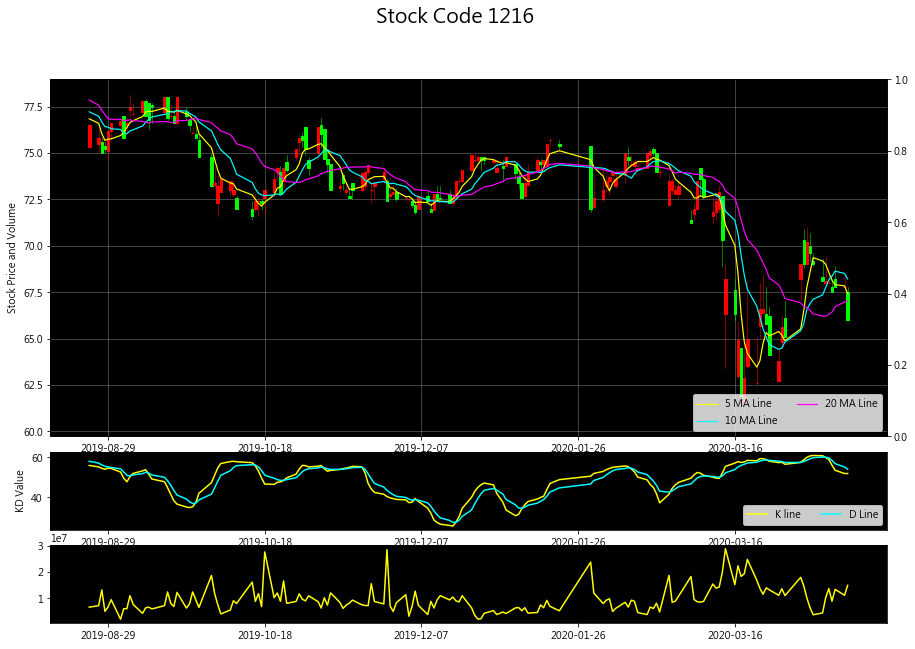

In [60]:
Ma_5 = moving_average(data_df,5)
Ma_10 = moving_average(data_df,10)
Ma_20 = moving_average(data_df,20)
Ma_60 = moving_average(data_df,60)
Ma_120 = moving_average(data_df,120)
Ma_Len = len(data_df['DateTime'])-(120-1) #配合Ma_120，也因為此行的關係資料一定要大於120畫圖才會正確
fig = plt.figure(facecolor='white',figsize=(15,10))
ax1 = plt.subplot2grid((6,4), (0,0),rowspan=4, colspan=4, facecolor='k')
candlestick_ohlc(ax1, data_df.values[-Ma_Len:],width=0.8,colorup='red',colordown='lime')
ax1.plot(data_df['DateTime'].values[-Ma_Len:],Ma_5[-Ma_Len:],'yellow',label='5 MA Line', linewidth=1.2) 
ax1.plot(data_df['DateTime'].values[-Ma_Len:],Ma_10[-Ma_Len:],'cyan',label='10 MA Line', linewidth=1.2)
ax1.plot(data_df['DateTime'].values[-Ma_Len:],Ma_20[-Ma_Len:],'magenta',label='20 MA Line', linewidth=1.2)
#ax1.plot(data_df['DateTime'].values[-Ma_Len:],Ma_60[-Ma_Len:],'turquoise',label='60 MA Line', linewidth=1.2)
#ax1.plot(data_df['DateTime'].values[-Ma_Len:],Ma_120[-Ma_Len:],'tomato',label='120 MA Line', linewidth=1.2)
#上面這行，第一個輸入為多個x，第二個輸入為多個y，會兩相一個一個對應
ax1.legend(loc='lower right',ncol=2)
ax1.grid(True, color='grey',linewidth=0.5) #把圖切成格子狀
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) #顯示出x軸的日期
ax1.yaxis.label.set_color("black") #設置y軸標籤顏色
plt.ylabel('Stock Price and Volume') #設置y軸標籤名字
plt.suptitle('Stock Code %d'%StockCode,color='black',fontsize=20) #suptitle=Main figure title (但跟title有差嗎ˊˇˋ???? 小圖是用set_title阿ˊˇˋ???

#畫交易量
ax1v = ax1.twinx() #ax1共用x軸

#ax1v.fill_between(data_df['DateTime'].values[-Ma_Len:],0, data['Volume'].values[-Ma_Len:], facecolor='navy', alpha=.4)
#ax1v.fill_between畫交易量的圖形


#以下不知道在幹嘛，只是複製
#ax1v.axes.yaxis.set_ticklabels([])
#ax1v.grid(False)
#ax1v.set_ylim(0, 3*data.Volume.values.max())

#加入KD線在下方
ax2 = plt.subplot2grid((6,4), (4,0), sharex=ax1, rowspan=1, colspan=4, facecolor='black')
ax2.plot(data_df['DateTime'].values[-Ma_Len:],data['K'][-Ma_Len:],label='K line',color='yellow')
ax2.plot(data_df['DateTime'].values[-Ma_Len:],data['D'][-Ma_Len:],label='D Line',color='cyan')
ax2.legend(loc='lower right', ncol=2)
plt.ylabel('KD Value', color='black')

ax3 = plt.subplot2grid((6,4), (5,0), sharex=ax1, rowspan=1, colspan=4, facecolor='black')
listo = []

ax3.plot(data_df['DateTime'].values[-Ma_Len:],data['Volume'][-Ma_Len:],label='V line',color='yellow')
plt.show()


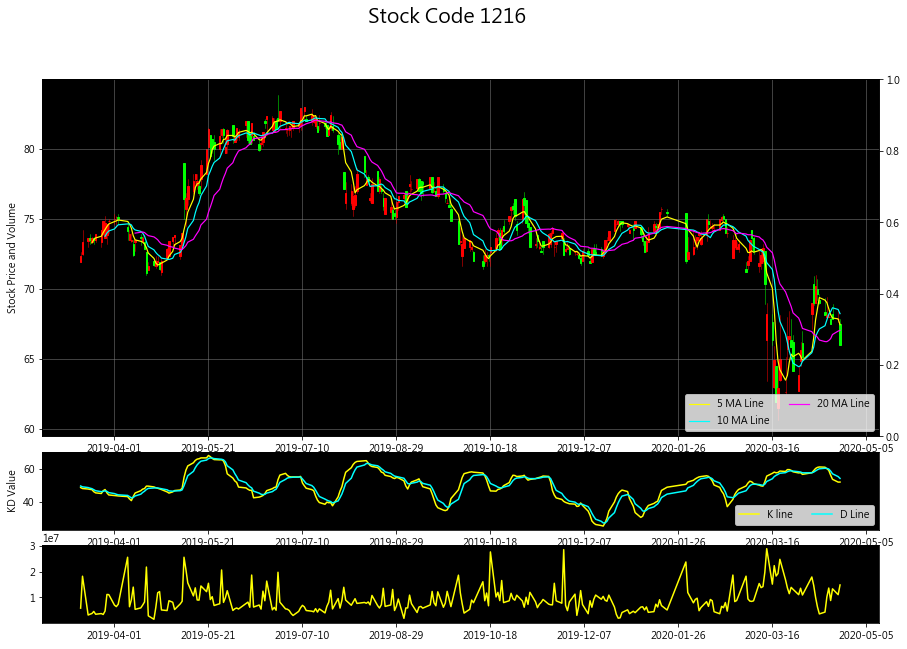

In [82]:
Ma_5 = moving_average(data_df2,5)
Ma_10 = moving_average(data_df2,10)
Ma_20 = moving_average(data_df2,20)
Ma_60 = moving_average(data_df2,60)
Ma_120 = moving_average(data_df2,120)
Ma_Len = len(data_df2['DateTime'])-(120-1) #配合Ma_120，也因為此行的關係資料一定要大於120畫圖才會正確
fig = plt.figure(facecolor='white',figsize=(15,10))
ax1 = plt.subplot2grid((6,4), (0,0),rowspan=4, colspan=4, facecolor='k')
candlestick_ohlc(ax1, data_df2.values[start:end],width=0.8,colorup='red',colordown='lime')
ax1.plot(data_df2['DateTime'].values[start:end],Ma_5[start:end],'yellow',label='5 MA Line', linewidth=1.2) 
ax1.plot(data_df2['DateTime'].values[start:end],Ma_10[start:end],'cyan',label='10 MA Line', linewidth=1.2)
ax1.plot(data_df2['DateTime'].values[start:end],Ma_20[start:end],'magenta',label='20 MA Line', linewidth=1.2)
#ax1.plot(data_df2['DateTime'].values[start:end],Ma_60[start:end],'turquoise',label='60 MA Line', linewidth=1.2)
#ax1.plot(data_df2['DateTime'].values[start:end],Ma_120[start:end],'tomato',label='120 MA Line', linewidth=1.2)
#上面這行，第一個輸入為多個x，第二個輸入為多個y，會兩相一個一個對應
ax1.legend(loc='lower right',ncol=2)
ax1.grid(True, color='grey',linewidth=0.5) #把圖切成格子狀
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) #顯示出x軸的日期
ax1.yaxis.label.set_color("black") #設置y軸標籤顏色
plt.ylabel('Stock Price and Volume') #設置y軸標籤名字
plt.suptitle('Stock Code %d'%StockCode,color='black',fontsize=20) #suptitle=Main figure title (但跟title有差嗎ˊˇˋ???? 小圖是用set_title阿ˊˇˋ???

#畫交易量
ax1v = ax1.twinx() #ax1共用x軸

#ax1v.fill_between(data_df2['DateTime'].values[start:end],0, data['Volume'].values[start:end], facecolor='navy', alpha=.4)
#ax1v.fill_between畫交易量的圖形


#以下不知道在幹嘛，只是複製
#ax1v.axes.yaxis.set_ticklabels([])
#ax1v.grid(False)
#ax1v.set_ylim(0, 3*data.Volume.values.max())

#加入KD線在下方
ax2 = plt.subplot2grid((6,4), (4,0), sharex=ax1, rowspan=1, colspan=4, facecolor='black')
ax2.plot(data_df2['DateTime'].values[start:end],data['K'][start:end],label='K line',color='yellow')
ax2.plot(data_df2['DateTime'].values[start:end],data['D'][start:end],label='D Line',color='cyan')
ax2.legend(loc='lower right', ncol=2)
plt.ylabel('KD Value', color='black')

ax3 = plt.subplot2grid((6,4), (5,0), sharex=ax1, rowspan=1, colspan=4, facecolor='black')
listo = []

ax3.plot(data_df2['DateTime'].values[start:end],data['Volume'][start:end],label='V line',color='yellow')
plt.show()


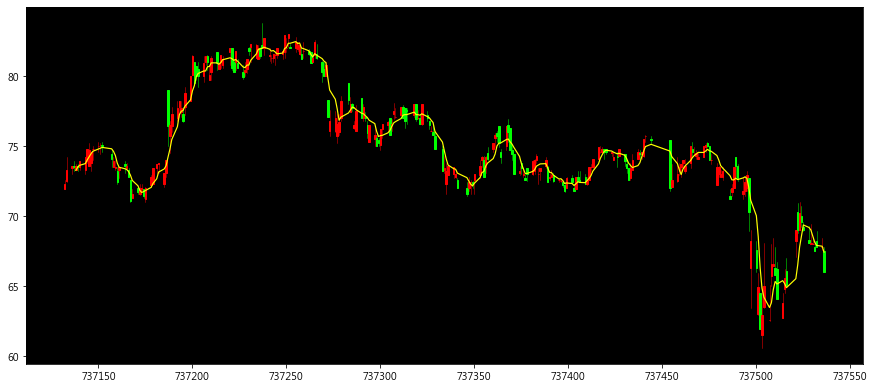

KeyError: 0

In [85]:
Ma_5 = moving_average(data_df2,5)
Ma_10 = moving_average(data_df2,10)
Ma_20 = moving_average(data_df2,20)
Ma_60 = moving_average(data_df2,60)
Ma_120 = moving_average(data_df2,120)
Ma_Len = len(data_df2['DateTime'])-(120-1) #配合Ma_120，也因為此行的關係資料一定要大於120畫圖才會正確
fig = plt.figure(facecolor='white',figsize=(15,10))
ax1 = plt.subplot2grid((6,4), (0,0),rowspan=4, colspan=4, facecolor='k')
candlestick_ohlc(ax1, data_df2.values[start:end],width=0.8,colorup='red',colordown='lime')
ax1.plot(data_df2['DateTime'].values[start:end],Ma_5[start:end],'yellow',label='5 MA Line', linewidth=1.2) 

plt.show()
print(Ma_5[0])
#沒有如預期指出現那幾天

In [ ]:
#https://openwritings.net/pg/mplfinance/python-draw-candlestickohlc-using-new-mplfinance
mpf.plot(data,type='candle',mav=(3,6,9),style = 'charles',title ='Stock price',ylabel='Price ($)',volume = True)
#,style = 'charles'

In [ ]:
'''
#廢物備用1
print(data.index)
# RangeIndex(start=0, stop=5, step=1)

# convert the column (it's a string) to datetime type
datetime_series = pd.to_datetime(data['Date'])

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)

data2=df.set_index(datetime_index)

# we don't need the column anymore
data2.drop('Date',axis=1,inplace=True)

print(df2.index)
# DatetimeIndex(['2000-01-01', '1999-12-20', '2000-11-01', '1995-02-25',
#    '1992-06-30'], dtype='datetime64[ns]', freq=None)
print(data)


#廢物備用2
mpf.plot(data,type ='candle', style = 'charles',title ='Stock price', ylabel = 'Price($)', volume=True)

#廢物備用3
data = data.set_index(pd.DatetimeIndex(df['Date']))
data

#廢物備用4
#datetime 作為Index
data['Date'] =  pd.to_datetime(data['Date'], format='%d%b%Y:%H:%M:%S.%f')
data.set_index(data['Date'])
print(data)


'''
'''這是一個，唯一畫的出圖，阿但是我什麼都不懂的程式碼^ ^'''
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import pandas as pd
import matplotlib.dates as mpl_dates

plt.style.use('ggplot')

# Extracting Data for plotting

ohlc = data.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)

# Creating Subplots
fig, ax = plt.subplots()
plt.axis('off')
fig.patch.set_facecolor('black')

candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

print(data)
plt.show()
